# ディープラーニングの学習メカニズム

## 学習とはパラメータの推定である  
問題: 観測機器(アナログ温度計)の校正(キャリブレーション)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import japanize_matplotlib # 日本語対応
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

### データ収集

In [3]:
# ノイズが含まれた観測値
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] # 摂氏温度
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # 未知の単位の値
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

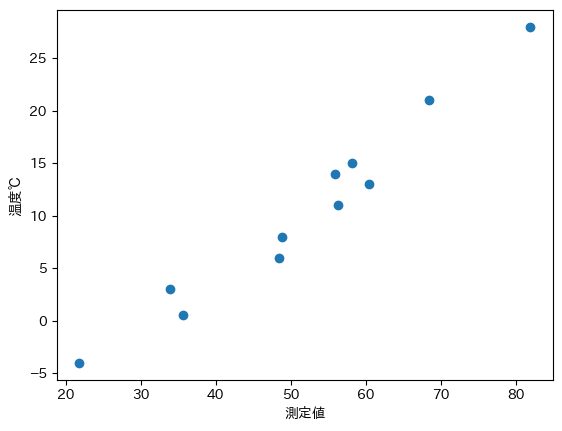

In [4]:
plt.scatter(t_u.numpy(),t_c.numpy())
plt.ylabel('温度℃')
plt.xlabel('測定値')
plt.show() 

### 損失関数

In [5]:
def model(t_u, w, b):
    return w * t_u + b

In [6]:
def loss_fn(t_p, t_c):
    squared_diff = (t_p - t_c)**2
    return squared_diff.mean()

In [7]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [8]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

### 勾配降下法

各パラメータに微小な変化量を与えて, 損失関数の変化量を観測する

In [9]:

delta = 0.1

loss_w1 = loss_fn(model(t_u, w + delta, b), t_c)
loss_w2 = loss_fn(model(t_u, w + delta, b), t_c)

loss_rate_of_change_w = (loss_w1 - loss_w2) / (2.0 * delta)
loss_rate_of_change_w

tensor(0.)

パラメータを微小に増加させて損失が減少傾向ならパラメータを増加させる.  
一方, 損失が増加傾向ならパラメータを減少させる.

In [10]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w
w

tensor(1.)

In [11]:
loss_b1 = loss_fn(model(t_u, w, b + delta), t_c)
loss_b2 = loss_fn(model(t_u, w, b - delta), t_c)

loss_rate_of_change_b = (loss_b1 - loss_b2) / (2.0 * delta)
loss_rate_of_change_b

tensor(82.5995)

In [12]:
b = b - learning_rate * loss_rate_of_change_b
b

tensor(-0.8260)

パラメータの微小変化量delta=0.1と設定したが, 損失がdeltaと比較して急速に変化する場合,  
どの方向に損失が最も減少しているのかわからない. なので, deltaはwとbの損失に基づいて計算する.  
つまり, 現パラメータ近傍に関する損失の導関数(微分値)を利用する.

In [13]:
# loss = f(t_p)の導関数(dloss/dt_p)
def dloss_fn(t_p, t_c):
    dsq_diff = 2 * (t_p - t_c) / t_p.size(0) # データ数Nで除算
    return dsq_diff

In [14]:
# t_p = f(t_u)の導関数(dt_p/dw, dt_p/db)
def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

In [15]:
# w, bに関する損失の導関数(dloss/dw, dloss/db)
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [16]:
# 訓練ループ
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        # 順伝搬
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)

        # 逆伝搬
        grad = grad_fn(t_u, t_c, t_p, w, b)

        # パラメータ更新
        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>

    return params

学習率が不適切で損失が増大している

In [17]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)


Epoch 1, Loss 1763.884766
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901105189019073810297959556841472.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

学習率が適切で損失が減少している

In [18]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

問題あり. Epoch1のwとbの勾配を見てみると, 重みの勾配がバイアスの勾配の約50倍もある.  
これは, 重みとバイアスで異なるスケールの物理空間に存在しているため.  
　
この場合, 片方を更新するのに十分な大きさの学習率は, もう片方を不安定にするほど大きくなり,  
もう片方に適した学習率は片方を変更するのに十分な大きさではない.

In [19]:
# パラメータ毎に異なる学習率を設定できるがパラメータ数が増大すると収集がつかなくなる.
# そこで, 各入力の物理空間のスケールをあわせるために入力の正規化を行う.

# 今回はt_uを0.1倍して[0.0, 1.0]に収まるようにする
t_un = 0.1 * t_u

In [20]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

In [21]:
# Epoch500, lr = 1e-2
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])
...
Epoch 4000, Loss 2.927680
    Params: tensor([  5.3643, -17.2853])
    Grad:   tensor([-0.0006,  0.0033])
Epoch 5000, Loss 2.927648
    Params: tensor([  5.3671, -17.3012])
    Grad:   tensor([-0.0001,  0.0006])


再度可視化する

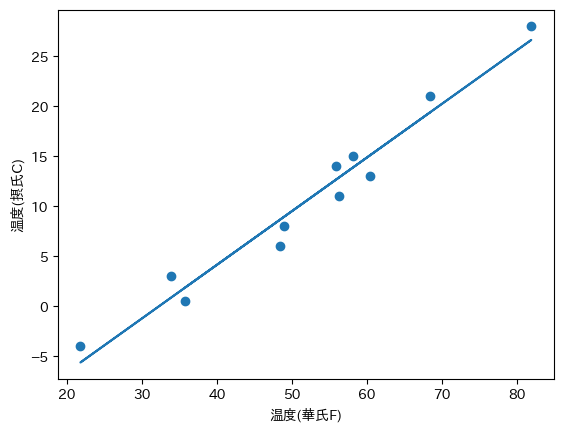

In [22]:
t_p = model(t_un, *params)

# fig = plt.figure(dpi=600)
plt.xlabel("温度(華氏F)")
plt.ylabel("温度(摂氏C)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.scatter(t_u.numpy(), t_c.numpy())
plt.show()

# Pytorchによるバックプロパゲーション

自動微分

In [23]:
autograd_params = torch.tensor([1.0, 0.0], requires_grad=True)

required_gradをTrueにしたテンソル(params)を祖先に持つ全テンソルは, paramsからそのテンソルに到達するために呼び出された関数  
の連鎖にアクセスすることができる.

In [24]:
autograd_params.grad is None

True

gradを利用するためには, required_gradをTrueに設定したテンソルを起点にモデルを呼び出して損失関数を計算し,   
損失値のテンソルからbackwordメソッドを呼ぶ.

### 勾配関数の累積

現在は既にgradが計算されているノードに対して再度勾配計算を行い, 累積しようとするとRuntimeErrorが発生する.  
累積さえるにはretrain_graph=Trueにする.  

In [25]:
loss = loss_fn(model(t_u, *autograd_params), t_c)
print("loss ", loss)
loss.backward(retain_graph=True) # paramsまでの逆誤差伝搬を開始 (retain_graph=Trueで勾配の累積を許す)
print("autograd_params.grad", autograd_params.grad)

loss  tensor(1763.8848, grad_fn=<MeanBackward0>)
autograd_params.grad tensor([4517.2969,   82.6000])


backward()を呼び出すと計算グラフの末端ノードに導関数の結果が累積されていく(dloss/dNode).  
そのため, パラメータ更新後は, 勾配を明示的にゼロにする必要がある. 

In [26]:
loss.backward(retain_graph=True) # paramsまでの逆誤差伝搬を開始
print("autograd_params.grad", autograd_params.grad) # 勾配が2倍になっている!

autograd_params.grad tensor([9034.5938,  165.2000])


### パラメータ更新毎に勾配をゼロにしながらバックプロパゲーションを行う


In [27]:
def training_loop2(n_epochs, learning_rage, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()

        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()

        # with文内でpytorchの計算グラフ(順伝搬のグラフ)にノードを追加連結しないようにする(autogradメカニズムをOFF)
        with torch.no_grad():
            params -= learning_rage * params.grad
        
        if epoch % 500 == 0:
            print("Epoch %d, Loss %f" % (epoch, float(loss)))

    return params

In [28]:
training_loop2(
    n_epochs=5000,
    learning_rage=1e-2,
    params=torch.tensor([1.0, 0.0], requires_grad=True),
    t_u=t_un,
    t_c=t_c
)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

## オプティマイザ(最適化アルゴリズム)

In [29]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

引数にrequires_grad=Trueのテンソルを渡す. 各Optimizerクラスにはzero_grad()とstep()の2種類のメソッドが用意されている.  
+ zero_grad() : 構築時に渡されているすべてのパラメータ変数のgradをゼロにする
+ step() : 最適化戦略によってパラメータを更新する

In [30]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [31]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [32]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [33]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params, # <1> 
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [34]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_u = t_u, # <2> 
    t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644
Epoch 2500, Loss 2.927645
Epoch 3000, Loss 2.927646
Epoch 3500, Loss 2.927645
Epoch 4000, Loss 2.927646
Epoch 4500, Loss 2.927646
Epoch 5000, Loss 2.927645


tensor([  0.5368, -17.3048], requires_grad=True)

## 訓練、検証と過学習

データセットの分割

In [35]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 3,  4, 10,  0,  6,  1,  2,  8,  7]), tensor([9, 5]))

In [36]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [39]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}, Validation loss {val_loss.item():.4f}")

In [40]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, # <1> 
    val_t_u = val_t_un, # <1> 
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 91.7660, Validation loss 29.0568
Epoch 2, Training loss 43.7766, Validation loss 2.3025
Epoch 3, Training loss 36.0900, Validation loss 3.5195
Epoch 500, Training loss 7.0920, Validation loss 4.6118
Epoch 1000, Training loss 3.4116, Validation loss 4.0901
Epoch 1500, Training loss 2.9273, Validation loss 3.9970
Epoch 2000, Training loss 2.8636, Validation loss 3.9759
Epoch 2500, Training loss 2.8552, Validation loss 3.9700
Epoch 3000, Training loss 2.8541, Validation loss 3.9680
